In [1]:
import os
os.chdir('/Users/nico/Desktop/Github')
print(os.getcwd())

/Users/nico/Desktop/Github


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import numpy as np

In [3]:
df = pd.read_csv('sarcasm_detection/data/corpora_dataset.csv', sep=';')
df.head()

,titles,category,Label
0,"Trentino, femministe chiedono l'abbattimento d...",cronaca,1
1,"""Voglio essere come lui!"" Bambino guarda video...",cronaca,1
2,"""Vorrei staccare la spina"". Sospeso medico ria...",cronaca,1
3,"Gatta muore al pronto soccorso per animali, ve...",cronaca,1
4,"Bologna, Comune installa sui semafori piccioni...",cronaca,1


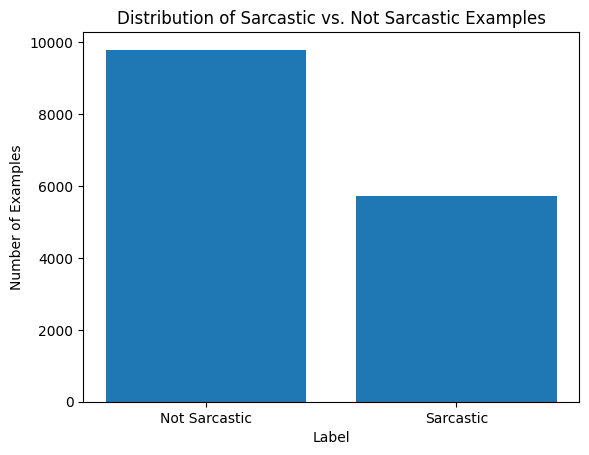

In [4]:
label_counts = df['Label'].value_counts()

label_names = ['Not Sarcastic', 'Sarcastic']

plt.bar(label_names, label_counts)
plt.xlabel('Label')
plt.ylabel('Number of Examples')
plt.title('Distribution of Sarcastic vs. Not Sarcastic Examples')
plt.show()

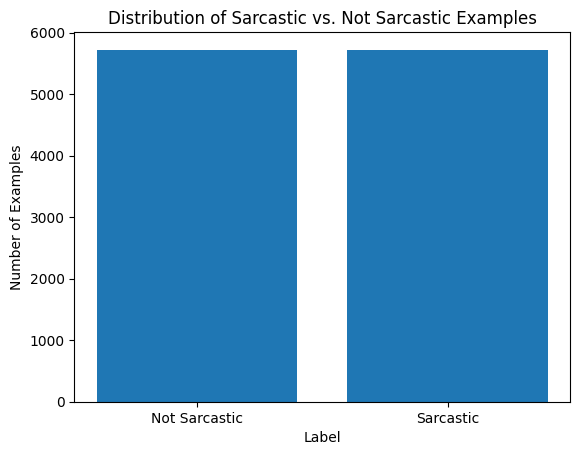

In [5]:
n_positive = df[df['Label'] == 1].shape[0]  # Number of sarcastic examples
n_negative = df[df['Label'] == 0].shape[0]  # Number of non-sarcastic examples

rows_to_remove = n_negative - n_positive

if pd.api.types.is_numeric_dtype(df.index):  # If index is numeric
    rows_to_delete = np.random.choice(df[df['Label'] == 0].index, rows_to_remove, replace=False)
else:  # If index is not numeric (e.g., strings)
    rows_to_delete = list(df[df['Label'] == 0].sample(rows_to_remove, replace=False).index)

df = df.drop(rows_to_delete)


label_counts = df['Label'].value_counts()

label_names = ['Not Sarcastic', 'Sarcastic']

plt.bar(label_names, label_counts)
plt.xlabel('Label')
plt.ylabel('Number of Examples')
plt.title('Distribution of Sarcastic vs. Not Sarcastic Examples')
plt.show()

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/nico/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

df = df[df['titles'].str.len() >= 20] # remove short titles

df['titles'] = df['titles'].str.lower() # lowercasing

df['titles'] = df['titles'].str.replace('[^\w\s]', '', regex=True) # removing punctuation

# Removing stop words
stop = set(stopwords.words('italian'))
df['titles'] = df['titles'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop]))

# lemmatization
lemmatizer = WordNetLemmatizer()
df['titles'] = df['titles'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

# remove extra whitespace
df['titles'] = df['titles'].str.strip()
df['titles'] = df['titles'].str.replace('\s+', ' ', regex=True)

df.head()

,titles,category,Label
0,trentino femministe chiedono labbattimento del...,cronaca,1
1,voglio essere bambino guarda video salvini dec...,cronaca,1
2,vorrei staccare spina sospeso medico rianimato...,cronaca,1
3,gatta muore pronto soccorso animali veterinari...,cronaca,1
4,bologna comune installa semafori piccioni adde...,cronaca,1


In [8]:
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(df['titles'], df['Label'], test_size=0.2, random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, random_state=42)

In [9]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

model_name = 'roberta-base'

# tokenizer
tokenizer = RobertaTokenizer.from_pretrained(model_name)

# Tokenize the texts
train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True)

val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True)

test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
import torch

# define a PyTorch dataset

class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
         self.encodings = encodings
         self.labels = labels
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]) 
        return item
        
    def __len__(self):
        return len(self.labels)

In [11]:
# convert our tokenized data into a torch datasets
train_dataset = SarcasmDataset(train_encodings, train_labels.tolist())
val_dataset = SarcasmDataset(val_encodings, val_labels.tolist())
test_dataset = SarcasmDataset(test_encodings, test_labels.tolist())

In [12]:
model = RobertaForSequenceClassification.from_pretrained(model_name)  # num_labels=2 for binary classification

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
def delete_existing_log_files(logging_dir):
    if os.path.exists(logging_dir):
        for filename in os.listdir(logging_dir):
            file_path = os.path.join(logging_dir, filename)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    os.rmdir(file_path)
            except Exception as e:
                print(f'Failed to delete {file_path}. Reason: {e}')

In [14]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir='./outputs',
    num_train_epochs=6,
    per_device_train_batch_size=48,
    per_device_eval_batch_size=32,
    warmup_steps=100,
    learning_rate=0.0001,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=100,
    evaluation_strategy='steps',
    save_steps=200,
    eval_steps=200,
    load_best_model_at_end=True,
    save_total_limit=2
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

In [15]:
delete_existing_log_files(training_args.logging_dir)

In [16]:
trainer.train()

Step,Training Loss,Validation Loss
200,0.502200,0.520653
400,0.414700,0.435988
600,0.304900,0.367948
800,0.205800,0.334929
1000,0.135700,0.408962


TrainOutput(global_step=1146, training_loss=0.30655277565927824, metrics={'train_runtime': 2366.2647, 'train_samples_per_second': 23.206, 'train_steps_per_second': 0.484, 'total_flos': 1467370355742720.0, 'train_loss': 0.30655277565927824, 'epoch': 6.0})

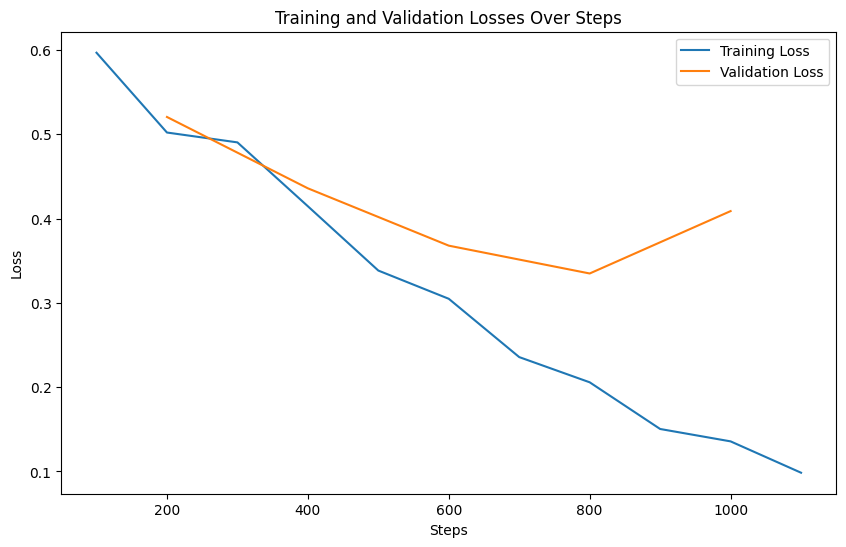

In [17]:
train_stats = trainer.state.log_history

train_loss = [x['loss'] for x in train_stats if 'loss' in x]
eval_loss = [x['eval_loss'] for x in train_stats if 'eval_loss' in x]

train_steps = [x['step'] for x in train_stats if 'loss' in x]
eval_steps = [x['step'] for x in train_stats if 'eval_loss' in x]

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label='Training Loss')
plt.plot(eval_steps, eval_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Losses Over Steps')
plt.show()

In [18]:
# Evaluate the model
eval_results = trainer.evaluate(test_dataset)

# Print evaluation results
print(eval_results)

# Predict on new data
predictions = trainer.predict(test_dataset)

# The predictions are in logits. Convert them to class labels.
predicted_labels = np.argmax(predictions.predictions, axis=1)

print(predicted_labels)

{'eval_loss': 0.39539825916290283, 'eval_runtime': 5.9695, 'eval_samples_per_second': 191.807, 'eval_steps_per_second': 6.031, 'epoch': 6.0}
[1 1 1 ... 0 1 1]


In [19]:
df_pred = pd.DataFrame({
    'titles': test_texts,
    'Label': test_labels
})

df_pred['predictions'] = predicted_labels

df_pred.head()

,titles,Label,predictions
4092,terra fuochi campania celebra eccellenze inaug...,1,1
1701,salvini sbaglia redigere comunicato estende li...,1,1
2036,meeting fdi giorgia meloni prende distanze fas...,1,1
9992,accordo cessate fuoco gaza entro lunedì cosa c...,0,0
730,crollo viadotto torinosavona protezione civile...,1,1


In [20]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_predictions(df):
    errors = df[df['Label'] != df['predictions']]
    num_errors = len(errors)
    
    print(f"\nNumber of errors: {num_errors}\n")
    
    accuracy = accuracy_score(df['Label'], df['predictions'])
    f1 = f1_score(df['Label'], df['predictions'])
    precision = precision_score(df['Label'], df['predictions'])
    recall = recall_score(df['Label'], df['predictions'])

    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}\n")

    print("Misclassified titles:\n")
    for index, row in errors.iterrows():
        label = "sarcastic" if row['Label'] == 1 else "not sarcastic"
        prediction = "sarcastic" if row['predictions'] == 1 else "not sarcastic"
        print(f"Title: {row['titles']}, Label: {label}, Prediction: {prediction}")

In [21]:
evaluate_predictions(df_pred)


Number of errors: 163

Accuracy: 0.8576419213973799
F1 Score: 0.8688656476267096
Precision: 0.8294930875576036
Recall: 0.9121621621621622

Misclassified titles:

Title: francesco corvaro nuovo inviato clima farnesina nominato tajani pichetto fratin, Label: not sarcastic, Prediction: sarcastic
Title: prosegue sciame sismico intorno parma spoleto umbria scuole chiuse scosse, Label: not sarcastic, Prediction: sarcastic
Title: arriva nuovo brano inedito beatles 2 novembre esce now and then stato realizzato, Label: not sarcastic, Prediction: sarcastic
Title: convivenza neanderthal prima previsto lenigma irrisolto due teschi, Label: not sarcastic, Prediction: sarcastic
Title: renato brunetta stipendio cnel norma hoc governo meloni decreto pnrr, Label: not sarcastic, Prediction: sarcastic
Title: macron verso rimpasto governo dimette premier francese elisabeth borne, Label: not sarcastic, Prediction: sarcastic
Title: solo giorno iphone x 1 euro attenti cecchini, Label: sarcastic, Prediction: 

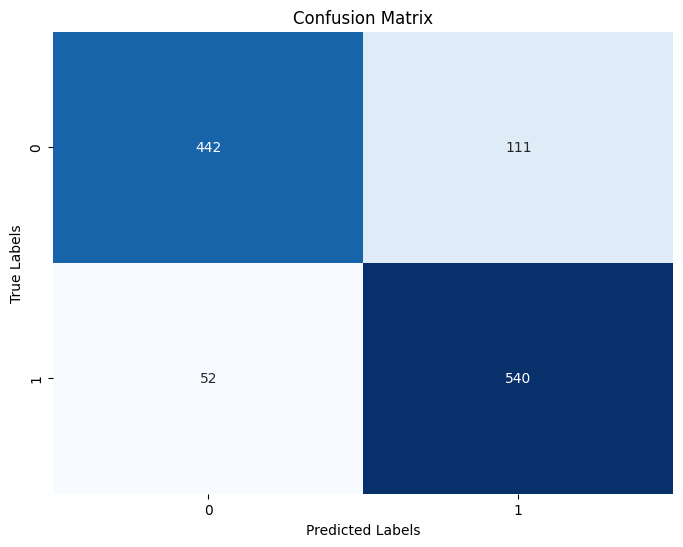

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = df_pred['Label']
predicted_labels = df_pred['predictions']

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

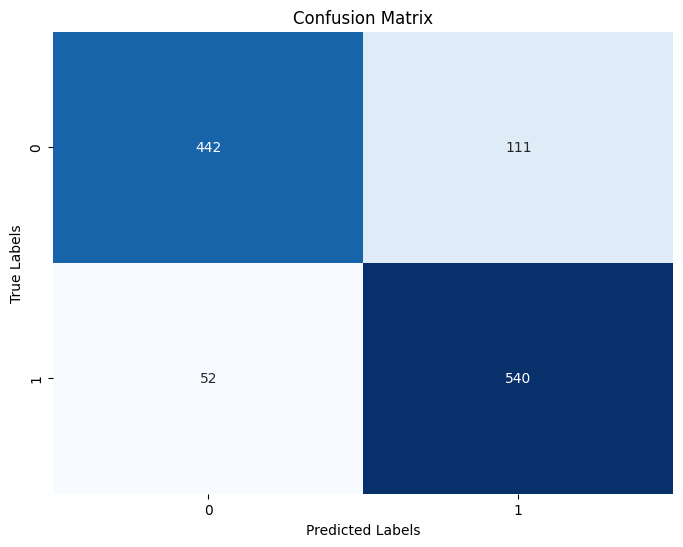

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

true_labels = df_pred['Label']
predicted_labels = df_pred['predictions']

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

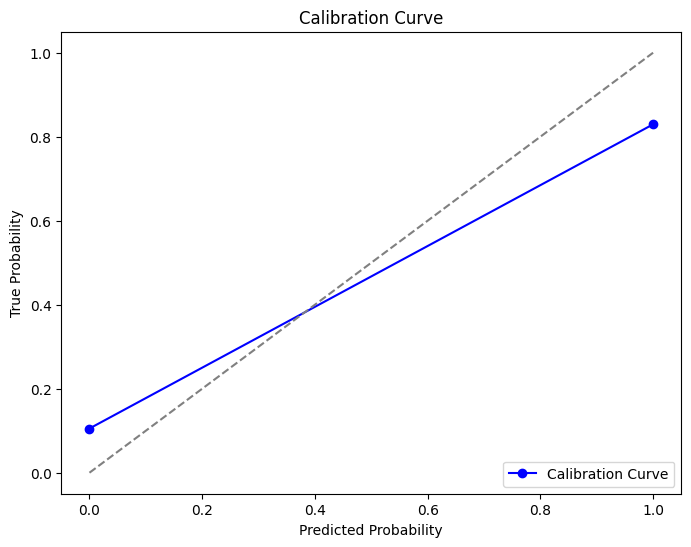

In [24]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(true_labels, predicted_labels, n_bins=10)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Calibration Curve', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend(loc='lower right')
plt.show()